In [1]:
import numpy as np
import xarray as xr

In [2]:
import sys
print(sys.path)
sys.path.append("/Users/dashadower/git_repos/stanify")

['/Users/dashadower/git_repos/stanify/vignette', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/dashadower/git_repos/stanify/venv/lib/python3.10/site-packages']


In [3]:
from stanify.builders.vensim2stan import Vensim2Stan

In [4]:
#vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/hier_prey_predator_wopnoise.mdl"
#vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/prey_predator_wopnoise.mdl"
vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/compare_vensim_stan.mdl"

In [5]:
v2s_code = """
//adj_frac1 ~ normal(0.5, 0.1);
ss_obs[timesteps] ~ normal(ss[timesteps], sigma);
//prey_obs[region, timesteps] ~ normal(prey[region, timesteps], sigma[region]);
sigma<lower=0.1> ~ lognormal(0, 1);
"""

In [6]:
max_time = 100

In [7]:
timesteps = np.arange(0, max_time, dtype=np.float32) + 1e-6

In [8]:
v2s = Vensim2Stan(v2s_code, vensim_model_path, "ss_obs", 0, timesteps, additional_data={"exog demand": xr.DataArray(2 * timesteps + 100, dims=["timesteps"], coords={"timesteps": timesteps.astype(np.integer)})})

/var/folders/dr/wk6zc3jn4s36h5dvr9w2tc_r0000gn/T/ipykernel_7411/1868211444.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  v2s = Vensim2Stan(v2s_code, vensim_model_path, "ss_obs", 0, timesteps, additional_data={"exog demand": xr.DataArray(2 * timesteps + 100, dims=["timesteps"], coords={"timesteps": timesteps.astype(np.integer)})})


In [9]:
sbc_idata = v2s.run_sbc(n_fits=10, n_draws=500, n_chains=4, iter_warmup=500)

Running SBC for dataset # 10 of 10


10:55:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:56:04 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
sbc_idata.prior.dims

Frozen({'prior_draw': 10, 'initial_state_dim_0': 4, 'ode_result_dim_0': 100, 'ode_result_dim_1': 4, 'timesteps': 100})

In [11]:
from stanify.calibrator.plots import plot_ecdf, plot_rank_hist

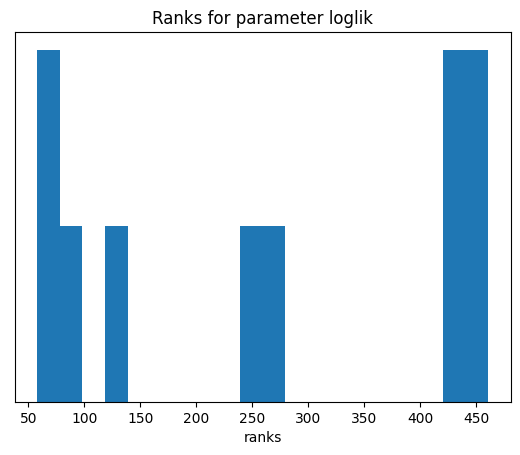

In [18]:
plot_rank_hist(sbc_idata, "loglik")

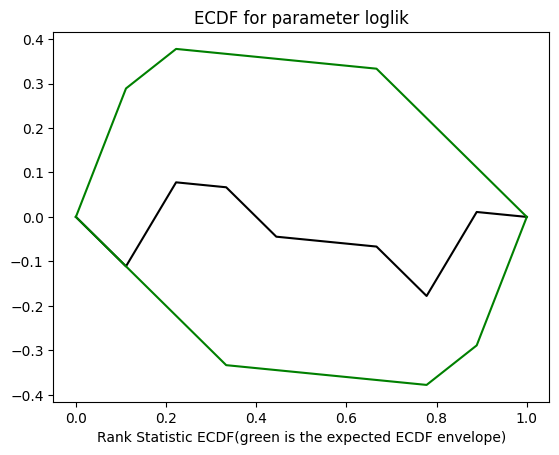

In [19]:
plot_ecdf(sbc_idata, "loglik", diff=True)

In [14]:
sbc_idata

Inference data with groups:
	> posterior
	> prior
	> prior_predictive
	> sample_stats_prior

In [15]:
import matplotlib.pyplot as plt

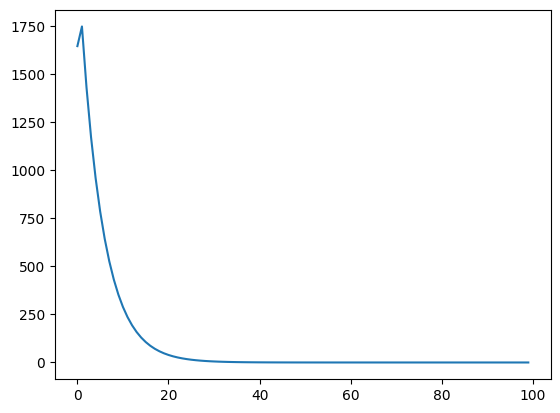

In [16]:
plt.plot(sbc_idata.posterior["ss"].sel(prior_draw=0).mean(dim="posterior_draw"))

In [17]:
sbc_idata.posterior["adj_s"].sel(prior_draw=0)

<xarray.DataArray 'adj_s' (posterior_draw: 500)>
array([228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
...
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773, 228.773, 228.773, 228.773, 228.773,
       228.773, 228.773, 228.773])
Coordinates:
    chain    (posterior_draw) int64 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    draw     (posterior_draw) int64 0 1 2 3 4 5 6 ... 119 120 121 122 123 124
Dimensions without coordinates: posterior_draw